In [18]:
# Code for deep recurrent Q learning
# Paper: Deep Recurrent Q-Learning for Partially Observable MDPs
# Paper url: https://arxiv.org/pdf/1507.06527.pdf

import gym, random, pickle, os.path, math, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import pdb
import os

from atari_wrappers import make_atari, wrap_deepmind, LazyFrames
from IPython.display import clear_output
from tensorboardX import SummaryWriter

USE_CUDA = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

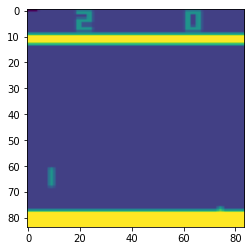

In [19]:
# Create and wrap the environment
env = make_atari('PongNoFrameskip-v4') # only use in no frameskip environment
env = wrap_deepmind(env, scale = False, frame_stack=True )
n_actions = env.action_space.n
state_dim = env.observation_space.shape

# env.render()
test = env.reset()
for i in range(100):
    test = env.step(env.action_space.sample())[0]

plt.imshow(test._force()[...,0])

# plt.imshow(env.render("rgb_array"))
# env.close()

In [20]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, num_actions=5):
        """
        Initialize a deep Q-learning network as described in
        https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
        Arguments:
            in_channels: number of channel of input.
                i.e The number of most recent frames stacked together as describe in the paper
            num_actions: number of action-value to output, one-to-one correspondence to action in game.
        """
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.contiguous().view(x.size(0), -1)))
        return self.fc5(x)


In [35]:
class Nstep_Memory_Buffer(object):
    # memory buffer to store episodic memory
    def __init__(self, memory_size=1000, n_multi_step = 1, gamma = 0.99):
        self.buffer = []
        self.memory_size = memory_size
        self.n_multi_step = n_multi_step
        self.gamma = gamma
        self.next_idx = 0
        
    def push(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) <= self.memory_size: # buffer not full
            self.buffer.append(data)
        else: # buffer is full
            self.buffer[self.next_idx] = data
        self.next_idx = (self.next_idx + 1) % self.memory_size

    def sample(self, batch_size):
        # sample episodic memory
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            finish = random.randint(self.n_multi_step, self.size() - 1)
            begin = finish-self.n_multi_step
            sum_reward = 0 # n_step rewards
            data = self.buffer[begin:finish]
            state = data[0][0]
            action = data[0][1]
            for j in range(self.n_multi_step):
                # compute the n-th reward
                sum_reward += (self.gamma**j) * data[j][2]
                if data[j][4]:
                    # manage end of episode
                    states_look_ahead = data[j][3]
                    done_look_ahead = True
                    break
                else:
                    states_look_ahead = data[j][3]
                    done_look_ahead = False
            
            states.append(state)
            actions.append(action)
            rewards.append(sum_reward)
            next_states.append(states_look_ahead)
            dones.append(done_look_ahead)

        return np.concatenate(states), actions, rewards, np.concatenate(next_states), dones
    
    def size(self):
        return len(self.buffer)


In [36]:
class Nstep_DQNAgent: 
    def __init__(self, in_channels = 1, action_space = [], USE_CUDA = False, memory_size = 10000, n_multi_step = 16, gamma = 0.99, epsilon  = 1, lr = 1e-4):
        self.epsilon = epsilon
        self.action_space = action_space
        self.n_multi_step = n_multi_step
        self.gamma = gamma 
        self.memory_buffer = Nstep_Memory_Buffer(memory_size, n_multi_step = n_multi_step, gamma = gamma)
        self.DQN = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target = DQN(in_channels = in_channels, num_actions = action_space.n)
        self.DQN_target.load_state_dict(self.DQN.state_dict())


        self.USE_CUDA = USE_CUDA
        if USE_CUDA:
            self.DQN = self.DQN.cuda()
            self.DQN_target = self.DQN_target.cuda()
        self.optimizer = optim.RMSprop(self.DQN.parameters(),lr=lr, eps=0.001, alpha=0.95)

    def observe(self, lazyframe):
        # from Lazy frame to tensor
        state =  torch.from_numpy(lazyframe._force().transpose(2,0,1)[None]/255).float()
        if self.USE_CUDA:
            state = state.cuda()
        return state

    def value(self, state):
        q_values = self.DQN(state)
        return q_values
    
    def act(self, state, epsilon = None):
        """
        sample actions with epsilon-greedy policy
        recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
        """
        if epsilon is None: epsilon = self.epsilon

        q_values = self.value(state).cpu().detach().numpy()
        if random.random()<epsilon:
            aciton = random.randrange(self.action_space.n)
        else:
            aciton = q_values.argmax(1)[0]
        return aciton
    
    def compute_td_loss(self, states, actions, rewards, next_states, is_done, gamma=0.99):
        """ Compute td loss using torch operations only. Use the formula above. """
        actions = torch.tensor(actions).long()    # shape: [batch_size]
        rewards = torch.tensor(rewards, dtype =torch.float)  # shape: [batch_size]
        is_done = torch.tensor(is_done).bool()  # shape: [batch_size]
        
        if self.USE_CUDA:
            actions = actions.cuda()
            rewards = rewards.cuda()
            is_done = is_done.cuda()

        # get q-values for all actions in current states
        predicted_qvalues = self.DQN(states)

        # select q-values for chosen actions
        predicted_qvalues_for_actions = predicted_qvalues[
          range(states.shape[0]), actions
        ]

        # compute q-values for all actions in next states
        predicted_next_qvalues = self.DQN_target(next_states) # YOUR CODE

        # compute V*(next_states) using predicted next q-values
        next_state_values =  predicted_next_qvalues.max(-1)[0] # YOUR CODE

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        target_qvalues_for_actions = rewards + (self.gamma**self.n_multi_step) *next_state_values

        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_qvalues_for_actions = torch.where(
            is_done, rewards, target_qvalues_for_actions)

        # mean squared error loss to minimize
        #loss = torch.mean((predicted_qvalues_for_actions -
        #                   target_qvalues_for_actions.detach()) ** 2)
        loss = F.smooth_l1_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

        return loss
    
    def sample_from_buffer(self, batch_size):
        # sample episodic memory
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in range(batch_size):
            finish = random.randint(self.n_multi_step, self.memory_buffer.size() - 1)
            begin = finish-self.n_multi_step
            sum_reward = 0 # n_step rewards
            data = self.memory_buffer.buffer[begin:finish]
            state = data[0][0] # s0
            action = data[0][1] # a0
            for j in range(self.n_multi_step):
                # compute the n-th reward
                sum_reward += (self.gamma**j) * data[j][2] # sum reward
                if data[j][4]:
                    # manage end of episode
                    states_look_ahead = data[j][3] # st
                    done_look_ahead = True
                    break
                else:
                    states_look_ahead = data[j][3] # st
                    done_look_ahead = False
            
            states.append(self.observe(state))
            actions.append(action)
            rewards.append(sum_reward)
            next_states.append(self.observe(states_look_ahead))
            dones.append(done_look_ahead)

        return torch.cat(states), actions, rewards, torch.cat(next_states), dones

    def learn_from_experience(self, batch_size):
        if self.memory_buffer.size() > batch_size:
            states, actions, rewards, next_states, dones = self.sample_from_buffer(batch_size)
            td_loss = self.compute_td_loss(states, actions, rewards, next_states, dones)
            self.optimizer.zero_grad()
            td_loss.backward()
            for param in self.DQN.parameters():
                param.grad.data.clamp_(-1, 1)

            self.optimizer.step()
            return(td_loss.item())
        else:
            return(0)
    

In [38]:
# if __name__ == '__main__':
    
# Training DQN in PongNoFrameskip-v4 
env = make_atari('PongNoFrameskip-v4')
env = wrap_deepmind(env, scale = False, frame_stack=True)

gamma = 0.99
epsilon_max = 1
epsilon_min = 0.05
eps_decay = 30000
frames = 1000000
USE_CUDA = True
learning_rate = 1e-4
max_buff = 100000
update_tar_interval = 1000
batch_size = 32
n_multi_step = 4
print_interval = 1000
log_interval = 1000
learning_start = 10000
win_reward = 18     # Pong-v4
win_break = True

action_space = env.action_space
action_dim = env.action_space.n
state_dim = env.observation_space.shape[0]
state_channel = env.observation_space.shape[2]
agent = Nstep_DQNAgent(in_channels = state_channel, action_space= action_space, USE_CUDA = USE_CUDA, lr = learning_rate, n_multi_step = n_multi_step, gamma = gamma)

frame = env.reset()

episode_reward = 0
all_rewards = []
losses = []
episode_num = 0
is_win = False
# tensorboard
summary_writer = SummaryWriter(log_dir = "Nstep_DQN", comment= "good_makeatari")

# e-greedy decay
epsilon_by_frame = lambda frame_idx: epsilon_min + (epsilon_max - epsilon_min) * math.exp(
            -1. * frame_idx / eps_decay)
# plt.plot([epsilon_by_frame(i) for i in range(10000)])

for i in range(frames):
    epsilon = epsilon_by_frame(i)
    state_tensor = agent.observe(frame)
    action = agent.act(state_tensor, epsilon)
    
    next_frame, reward, done, _ = env.step(action)
    
    episode_reward += reward
    agent.memory_buffer.push(frame, action, reward, next_frame, done)
    frame = next_frame
    
    loss = 0
    if agent.memory_buffer.size() >= learning_start:
        loss = agent.learn_from_experience(batch_size)
        losses.append(loss)

    if i % print_interval == 0:
        print("frames: %5d, reward: %5f, loss: %4f, epsilon: %5f, episode: %4d" % (i, np.mean(all_rewards[-10:]), loss, epsilon, episode_num))
        summary_writer.add_scalar("Temporal Difference Loss", loss, i)
        summary_writer.add_scalar("Mean Reward", np.mean(all_rewards[-10:]), i)
        summary_writer.add_scalar("Epsilon", epsilon, i)
        
    if i % update_tar_interval == 0:
        agent.DQN_target.load_state_dict(agent.DQN.state_dict())
    
    if done:
        
        frame = env.reset()
        
        all_rewards.append(episode_reward)
        episode_reward = 0
        episode_num += 1
        avg_reward = float(np.mean(all_rewards[-100:]))

summary_writer.close()


frames:     0, reward:   nan, loss: 0.000000, epsilon: 1.000000, episode:    0


frames:  1000, reward:   nan, loss: 0.000000, epsilon: 0.968855, episode:    0
frames:  2000, reward: -21.000000, loss: 0.000000, epsilon: 0.938732, episode:    1
frames:  3000, reward: -20.000000, loss: 0.000000, epsilon: 0.909596, episode:    2
frames:  4000, reward: -20.000000, loss: 0.000000, epsilon: 0.881415, episode:    3
frames:  5000, reward: -20.250000, loss: 0.000000, epsilon: 0.854158, episode:    4
frames:  6000, reward: -20.500000, loss: 0.000000, epsilon: 0.827794, episode:    6
frames:  7000, reward: -20.428571, loss: 0.000000, epsilon: 0.802295, episode:    7
frames:  8000, reward: -20.500000, loss: 0.000000, epsilon: 0.777632, episode:    8
frames:  9000, reward: -20.555556, loss: 0.000000, epsilon: 0.753777, episode:    9
frames: 10000, reward: -20.500000, loss: 0.075068, epsilon: 0.730705, episode:   10
frames: 11000, reward: -20.700000, loss: 0.053801, epsilon: 0.708389, episode:   12
frames: 12000, reward: -20.800000, loss: 0.079203, epsilon: 0.686804, episode:   

frames: 99000, reward: -16.900000, loss: 0.017712, epsilon: 0.085039, episode:   97
frames: 100000, reward: -16.900000, loss: 0.013828, epsilon: 0.083890, episode:   98
frames: 101000, reward: -16.900000, loss: 0.014143, epsilon: 0.082779, episode:   98
frames: 102000, reward: -16.600000, loss: 0.009617, epsilon: 0.081705, episode:   99
frames: 103000, reward: -16.600000, loss: 0.032885, epsilon: 0.080665, episode:   99
frames: 104000, reward: -16.400000, loss: 0.011300, epsilon: 0.079660, episode:  100
frames: 105000, reward: -16.400000, loss: 0.011319, epsilon: 0.078688, episode:  100
frames: 106000, reward: -16.500000, loss: 0.008643, epsilon: 0.077747, episode:  101
frames: 107000, reward: -16.500000, loss: 0.012676, epsilon: 0.076837, episode:  101
frames: 108000, reward: -16.200000, loss: 0.005347, epsilon: 0.075958, episode:  102
frames: 109000, reward: -16.200000, loss: 0.011709, epsilon: 0.075107, episode:  102
frames: 110000, reward: -16.000000, loss: 0.014729, epsilon: 0.074

frames: 196000, reward: -6.700000, loss: 0.016525, epsilon: 0.051381, episode:  140
frames: 197000, reward: -6.700000, loss: 0.005381, epsilon: 0.051336, episode:  140
frames: 198000, reward: -4.300000, loss: 0.004682, epsilon: 0.051292, episode:  141
frames: 199000, reward: -4.300000, loss: 0.003945, epsilon: 0.051250, episode:  141
frames: 200000, reward: -1.900000, loss: 0.035970, epsilon: 0.051209, episode:  142
frames: 201000, reward: -1.900000, loss: 0.005281, epsilon: 0.051169, episode:  142
frames: 202000, reward: 0.100000, loss: 0.012304, epsilon: 0.051131, episode:  143
frames: 203000, reward: 0.100000, loss: 0.006703, epsilon: 0.051094, episode:  143
frames: 204000, reward: 0.100000, loss: 0.014608, epsilon: 0.051058, episode:  143
frames: 205000, reward: 2.500000, loss: 0.002679, epsilon: 0.051023, episode:  144
frames: 206000, reward: 2.500000, loss: 0.004788, epsilon: 0.050990, episode:  144
frames: 207000, reward: 4.900000, loss: 0.006269, epsilon: 0.050957, episode:  14

frames: 294000, reward: 11.800000, loss: 0.003396, epsilon: 0.050053, episode:  184
frames: 295000, reward: 11.700000, loss: 0.003191, epsilon: 0.050051, episode:  185
frames: 296000, reward: 11.700000, loss: 0.005840, epsilon: 0.050049, episode:  185
frames: 297000, reward: 12.300000, loss: 0.015511, epsilon: 0.050048, episode:  186
frames: 298000, reward: 12.300000, loss: 0.002289, epsilon: 0.050046, episode:  186
frames: 299000, reward: 12.100000, loss: 0.001891, epsilon: 0.050045, episode:  187
frames: 300000, reward: 12.100000, loss: 0.004743, epsilon: 0.050043, episode:  187
frames: 301000, reward: 13.400000, loss: 0.004178, epsilon: 0.050042, episode:  188
frames: 302000, reward: 13.400000, loss: 0.003493, epsilon: 0.050040, episode:  188
frames: 303000, reward: 13.100000, loss: 0.008947, epsilon: 0.050039, episode:  189
frames: 304000, reward: 13.100000, loss: 0.002428, epsilon: 0.050038, episode:  189
frames: 305000, reward: 14.300000, loss: 0.010058, epsilon: 0.050037, episod

frames: 392000, reward: 12.800000, loss: 0.004464, epsilon: 0.050002, episode:  231
frames: 393000, reward: 13.100000, loss: 0.003384, epsilon: 0.050002, episode:  232
frames: 394000, reward: 13.100000, loss: 0.003640, epsilon: 0.050002, episode:  232
frames: 395000, reward: 14.300000, loss: 0.003016, epsilon: 0.050002, episode:  233
frames: 396000, reward: 14.300000, loss: 0.007654, epsilon: 0.050002, episode:  233
frames: 397000, reward: 14.600000, loss: 0.006500, epsilon: 0.050002, episode:  234
frames: 398000, reward: 14.600000, loss: 0.001966, epsilon: 0.050002, episode:  234
frames: 399000, reward: 14.600000, loss: 0.002414, epsilon: 0.050002, episode:  235
frames: 400000, reward: 14.600000, loss: 0.004889, epsilon: 0.050002, episode:  235
frames: 401000, reward: 14.600000, loss: 0.002120, epsilon: 0.050001, episode:  236
frames: 402000, reward: 14.600000, loss: 0.004138, epsilon: 0.050001, episode:  236
frames: 403000, reward: 14.800000, loss: 0.001605, epsilon: 0.050001, episod

frames: 490000, reward: 10.100000, loss: 0.008134, epsilon: 0.050000, episode:  277
frames: 491000, reward: 10.100000, loss: 0.005252, epsilon: 0.050000, episode:  277
frames: 492000, reward: 10.100000, loss: 0.005369, epsilon: 0.050000, episode:  277
frames: 493000, reward: 9.200000, loss: 0.001682, epsilon: 0.050000, episode:  278
frames: 494000, reward: 9.200000, loss: 0.003096, epsilon: 0.050000, episode:  278
frames: 495000, reward: 9.800000, loss: 0.002031, epsilon: 0.050000, episode:  279
frames: 496000, reward: 9.800000, loss: 0.005126, epsilon: 0.050000, episode:  279
frames: 497000, reward: 10.300000, loss: 0.005505, epsilon: 0.050000, episode:  280
frames: 498000, reward: 10.300000, loss: 0.006418, epsilon: 0.050000, episode:  280
frames: 499000, reward: 10.600000, loss: 0.004051, epsilon: 0.050000, episode:  281
frames: 500000, reward: 10.600000, loss: 0.010199, epsilon: 0.050000, episode:  281
frames: 501000, reward: 9.500000, loss: 0.005550, epsilon: 0.050000, episode:  2

frames: 588000, reward: 11.400000, loss: 0.002070, epsilon: 0.050000, episode:  321
frames: 589000, reward: 11.400000, loss: 0.002823, epsilon: 0.050000, episode:  321
frames: 590000, reward: 12.100000, loss: 0.002488, epsilon: 0.050000, episode:  322
frames: 591000, reward: 12.100000, loss: 0.001981, epsilon: 0.050000, episode:  322
frames: 592000, reward: 12.100000, loss: 0.003493, epsilon: 0.050000, episode:  322
frames: 593000, reward: 11.700000, loss: 0.003350, epsilon: 0.050000, episode:  323
frames: 594000, reward: 12.300000, loss: 0.003114, epsilon: 0.050000, episode:  324
frames: 595000, reward: 12.300000, loss: 0.001970, epsilon: 0.050000, episode:  324
frames: 596000, reward: 12.800000, loss: 0.006403, epsilon: 0.050000, episode:  325
frames: 597000, reward: 12.800000, loss: 0.002783, epsilon: 0.050000, episode:  325
frames: 598000, reward: 12.800000, loss: 0.004077, epsilon: 0.050000, episode:  325
frames: 599000, reward: 13.200000, loss: 0.006125, epsilon: 0.050000, episod

frames: 686000, reward: 12.700000, loss: 0.013262, epsilon: 0.050000, episode:  366
frames: 687000, reward: 12.700000, loss: 0.003589, epsilon: 0.050000, episode:  366
frames: 688000, reward: 12.500000, loss: 0.005112, epsilon: 0.050000, episode:  367
frames: 689000, reward: 12.500000, loss: 0.002149, epsilon: 0.050000, episode:  367
frames: 690000, reward: 13.300000, loss: 0.001669, epsilon: 0.050000, episode:  368
frames: 691000, reward: 13.300000, loss: 0.001755, epsilon: 0.050000, episode:  368
frames: 692000, reward: 13.200000, loss: 0.006534, epsilon: 0.050000, episode:  369
frames: 693000, reward: 13.200000, loss: 0.004343, epsilon: 0.050000, episode:  369
frames: 694000, reward: 12.800000, loss: 0.004090, epsilon: 0.050000, episode:  370
frames: 695000, reward: 12.800000, loss: 0.006033, epsilon: 0.050000, episode:  370
frames: 696000, reward: 11.900000, loss: 0.002395, epsilon: 0.050000, episode:  371
frames: 697000, reward: 11.900000, loss: 0.002055, epsilon: 0.050000, episod

frames: 784000, reward: 15.300000, loss: 0.005930, epsilon: 0.050000, episode:  411
frames: 785000, reward: 15.300000, loss: 0.003688, epsilon: 0.050000, episode:  412
frames: 786000, reward: 15.300000, loss: 0.005271, epsilon: 0.050000, episode:  412
frames: 787000, reward: 15.300000, loss: 0.003653, epsilon: 0.050000, episode:  413
frames: 788000, reward: 15.300000, loss: 0.001813, epsilon: 0.050000, episode:  413
frames: 789000, reward: 15.800000, loss: 0.002778, epsilon: 0.050000, episode:  414
frames: 790000, reward: 15.800000, loss: 0.003190, epsilon: 0.050000, episode:  414
frames: 791000, reward: 15.500000, loss: 0.004202, epsilon: 0.050000, episode:  415
frames: 792000, reward: 15.500000, loss: 0.001370, epsilon: 0.050000, episode:  415
frames: 793000, reward: 14.300000, loss: 0.002783, epsilon: 0.050000, episode:  416
frames: 794000, reward: 14.300000, loss: 0.005818, epsilon: 0.050000, episode:  416
frames: 795000, reward: 14.100000, loss: 0.004066, epsilon: 0.050000, episod

frames: 882000, reward: 14.200000, loss: 0.001250, epsilon: 0.050000, episode:  458
frames: 883000, reward: 14.200000, loss: 0.007638, epsilon: 0.050000, episode:  458
frames: 884000, reward: 14.400000, loss: 0.009678, epsilon: 0.050000, episode:  459
frames: 885000, reward: 14.400000, loss: 0.005562, epsilon: 0.050000, episode:  459
frames: 886000, reward: 14.300000, loss: 0.003816, epsilon: 0.050000, episode:  460
frames: 887000, reward: 14.300000, loss: 0.004365, epsilon: 0.050000, episode:  460
frames: 888000, reward: 14.000000, loss: 0.002744, epsilon: 0.050000, episode:  461
frames: 889000, reward: 14.800000, loss: 0.003915, epsilon: 0.050000, episode:  462
frames: 890000, reward: 14.800000, loss: 0.008042, epsilon: 0.050000, episode:  462
frames: 891000, reward: 14.800000, loss: 0.006498, epsilon: 0.050000, episode:  462
frames: 892000, reward: 14.700000, loss: 0.004728, epsilon: 0.050000, episode:  463
frames: 893000, reward: 14.700000, loss: 0.007257, epsilon: 0.050000, episod

frames: 980000, reward: 13.300000, loss: 0.002448, epsilon: 0.050000, episode:  503
frames: 981000, reward: 13.300000, loss: 0.001983, epsilon: 0.050000, episode:  503
frames: 982000, reward: 13.300000, loss: 0.002029, epsilon: 0.050000, episode:  504
frames: 983000, reward: 13.300000, loss: 0.009072, epsilon: 0.050000, episode:  504
frames: 984000, reward: 13.100000, loss: 0.005023, epsilon: 0.050000, episode:  505
frames: 985000, reward: 13.100000, loss: 0.008808, epsilon: 0.050000, episode:  505
frames: 986000, reward: 13.100000, loss: 0.004414, epsilon: 0.050000, episode:  505
frames: 987000, reward: 13.500000, loss: 0.004472, epsilon: 0.050000, episode:  506
frames: 988000, reward: 13.500000, loss: 0.001241, epsilon: 0.050000, episode:  506
frames: 989000, reward: 14.300000, loss: 0.001074, epsilon: 0.050000, episode:  507
frames: 990000, reward: 14.300000, loss: 0.002920, epsilon: 0.050000, episode:  507
frames: 991000, reward: 14.200000, loss: 0.003439, epsilon: 0.050000, episod

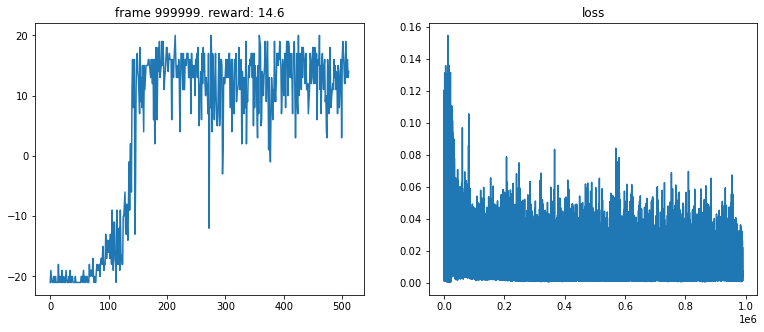

In [39]:
def plot_training(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

plot_training(i, all_rewards, losses)

In [8]:
test  =[1,2,3]
test[0:3]

[1, 2, 3]